# Text summary project
AIFFEL 대전 탐색 노드 11   

프로세스는 다음과 같다.     
1. Import package 
2. Data preprocessing
3. Modeling
4. Text summary
5. Analysis

## 1. Import package

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import requests
from summa.summarizer import summarize

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj28/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Data preprocessing

### Data loading

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
11442,I've been used: Kanye as he distances himself ...,American rapper Kanye West has announced that ...
86688,Air India to create makeshift business class u...,Air India has decided to reserve the first thr...
33017,Pawan Kalyan-led party to contest all Andhra A...,Actor-turned-politician Pawan Kalyan has annou...
46966,Eat beef if you want but why celebrate it: Vic...,Stating that people should eat beef if they wi...
2847,RBI allows 'tokenisation' for more secure card...,"To make card transactions more secure, the RBI..."
35375,All accused in 2007 Mecca Masjid blast case ac...,A special National Investigation Agency (NIA) ...
22546,Kohli-led Team India is 'undercooked': Ex-Eng ...,Former England captain Nasser Hussain has said...
36690,Kapil Sharma files complaint against journalis...,Kapil Sharma has filed a complaint against his...
52746,WB CM Mamata Banerjee receives honorary doctorate,West Bengal CM Mamata Banerjee on Thursday rec...
27560,Zomato appoints Mohit Gupta as startup's food...,The former Chief Operating Officer of MakeMyTr...


### Removing duplicate values

In [4]:
print('전체 샘플수 :',(len(data)))
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

전체 샘플수 : 98401
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [6]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


### Normalization & removing stopwords
정규화할 단어와 제거할 불용어를 미리 정의하고 이를 이용하여   
데이터에서 정규화와 불용어 제거를 한다.

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
# testing
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [11]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [12]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [13]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [15]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


### Data analysis (for length)
데이터의 길이 분포를 확인한다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


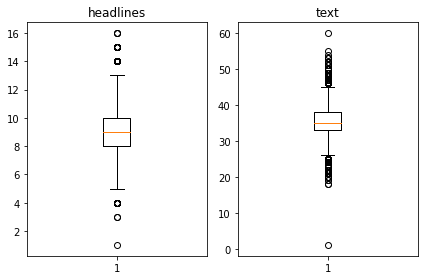

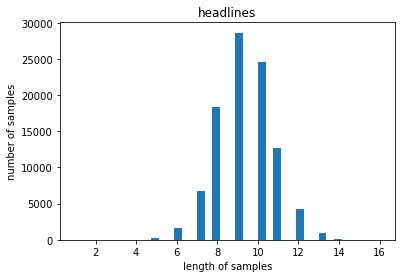

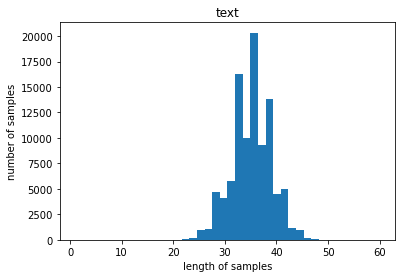

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Removing anomaly data
위에서 확인한 데이터 분포를 이용하여 길이가 긴 데이터를 제거한다.

In [17]:
text_max_len = 45
summary_max_len = 12

In [18]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 96871


In [21]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [22]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[23685 65068 70130 ... 41417 75466 10814]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19374


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


### Tokenization & encoding
단어 단위로 토큰화를 진행하고 단어를 정수로 바꾸는 인코딩을 한다.   
이 때에 빈도수가 작은 단어에 대해서 제거하는 작업도 함꼐 한다.

In [27]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [29]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69046
등장 빈도가 6번 이하인 희귀 단어의 수: 47014
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22032
단어 집합에서 희귀 단어의 비율: 68.09083799206326
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.502149978180095


In [30]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [32]:
#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[8748, 2617, 1935, 2187, 1504, 1314, 142, 246, 2080, 73, 423, 2, 318, 852, 3207, 9226, 2187, 9778, 1314, 1314, 861, 7510, 14665, 9226, 143, 17, 723, 142, 3287, 5696, 18264, 1242, 246], [448, 560, 160, 541, 114, 2, 2447, 1854, 18, 607, 1900, 462, 155, 1331, 307, 754, 2081, 114, 2966, 1122, 9404, 7971, 1596, 1925, 1528, 2498, 155, 1331, 4640, 3266, 111, 1900, 462], [424, 115, 2484, 928, 614, 1033, 738, 3046, 2284, 3599, 143, 4595, 1039, 1973, 2022, 370, 165, 59, 8, 6, 2177, 4200, 368, 385, 3153, 3101, 1462, 4079, 3101, 3230, 105, 355, 871, 7511, 15861, 424]]


In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [34]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [35]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29943
등장 빈도가 5번 이하인 희귀 단어의 수: 19595
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10348
단어 집합에서 희귀 단어의 비율: 65.44100457535986
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.720325944354772


In [36]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [37]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 141, 77, 6, 2758, 2373, 657, 1212, 1745], [1, 452, 2445, 2047, 51, 555, 5, 343, 2087, 674], [1, 1925, 2298, 3, 21, 1369, 5, 3980, 1809, 104, 1689], [1, 260, 20, 44, 5134, 256, 183, 4, 3364, 6777, 82], [1, 238, 19, 3365]]
target
decoder  [[141, 77, 6, 2758, 2373, 657, 1212, 1745, 2], [452, 2445, 2047, 51, 555, 5, 343, 2087, 674, 2], [1925, 2298, 3, 21, 1369, 5, 3980, 1809, 104, 1689, 2], [260, 20, 44, 5134, 256, 183, 4, 3364, 6777, 82, 2], [238, 19, 3365, 2]]


In [38]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0


In [39]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 77496
훈련 레이블의 개수 : 77496
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


### Padding
입력 형식을 맞춰주기 위해서 패딩을 해준다.

In [40]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## 3. Modeling
Text summary 작업을 위해서 seq2seq 모델을 사용한다.    
이 때에 Attention 기법을 추가한 모델이다.   
훈련과정과 추론과정의 동작이 다르기 때문에 추론과정을 위한 모델을 따로 만들어 주게 된다.

In [41]:
#modeling
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### Attention

In [42]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### Training

Epoch 1/50
303/303 [==============================] - 113s 374ms/step - loss: 5.6126 - val_loss: 5.2003
Epoch 2/50
303/303 [==============================] - 113s 372ms/step - loss: 5.0490 - val_loss: 4.8180
Epoch 3/50
303/303 [==============================] - 114s 375ms/step - loss: 4.6970 - val_loss: 4.5385
Epoch 4/50
303/303 [==============================] - 112s 371ms/step - loss: 4.4233 - val_loss: 4.3619
Epoch 5/50
303/303 [==============================] - 111s 366ms/step - loss: 4.2147 - val_loss: 4.1974
Epoch 6/50
303/303 [==============================] - 112s 371ms/step - loss: 4.0447 - val_loss: 4.0801
Epoch 7/50
303/303 [==============================] - 113s 373ms/step - loss: 3.8988 - val_loss: 3.9954
Epoch 8/50
303/303 [==============================] - 113s 373ms/step - loss: 3.7738 - val_loss: 3.9237
Epoch 9/50
303/303 [==============================] - 114s 375ms/step - loss: 3.6600 - val_loss: 3.8593
Epoch 10/50
303/303 [==============================] - 117s 386m

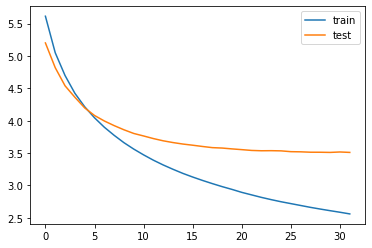

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Inference

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## 4. Text summary
seq2seq 모델(abstractive 요약)과 extractive 요약 모델(summa 이용)을 이용해서 text summary를 한다.

In [46]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : rajasthan royals making return ipl two year suspension named steve smith captain upcoming season smith player retained rajasthan royals ipl auction led rising pune supergiant final ipl announcement made rr mentor shane warne 
실제 요약 : rajasthan royals name steve smith as captain for ipl 
예측 요약 :  rajasthan royals to smith ipl team jersey for ipl


원문 : indian freedom fighter sarojini naidu became first female governor state independent india appointed governor united provinces uttar pradesh also known india naidu also served first indian woman president indian national congress born february 
실제 요약 : naidu was st female state governor of independent india 
예측 요약 :  who is the first female general of india


원문 : following wickets australia second test kagiso rabada test bowling strike rate best bowler plus wickets years rabada fourth wicket match haul joint second south african cricketer england george best strike rate test cricket history 
실제 요약 : rabada takes wkt every balls best

예측 요약 :  rohit sharma is not to be rohit sharma


원문 : beleaguered liquor baron vijay mallya tuesday offered settle bank dues selling assets sought permission karnataka high court filed application setting available assets approximately crore mallya said year old fled london march fighting extradition india 
실제 요약 : will settle all dues have assets worth cr mallya 
예측 요약 :  vijay mallya extradition sent to crore in july


원문 : former england cricketer shah former indian cricketer manoj prabhakar applied position indian women team coach earlier reports claimed former south african cricketer herschelle gibbs also applied position earlier year tushar stepped indian women team coach following ramesh powar held position 
실제 요약 : shah manoj apply for women team coach post 
예측 요약 :  ex england captain ganguly named women coach in cricket


원문 : japanese carmaker nissan recalled two lakh cars suvs us due fire risk anti lock brake pump leak brake fluid onto circuit board causing electrical shor

예측 요약 :  india to be world largest hc judges in hc


원문 : indian railways decided build km wall along delhi mumbai route order restrict human cattle interference officials said according official move approved railway board expected help railways achieve time performance reduce number accidents 
실제 요약 : railways to build km wall along delhi mumbai route 
예측 요약 :  railways to set up rail stations to track skyscraper


원문 : ministry external affairs recently launched initiative titled serving diplomats visit schools colleges interact students interact students way mea works basic elements policies diplomacy conducted also give students idea career options field 
실제 요약 : serving diplomats with students under mea scheme 
예측 요약 :  mea to allow students to college students


원문 : addressing delhi police personnel tuesday home minister rajnath singh said someone comes police station lodge complaint cannot talk stating request commissioner delhi police ensure arrangements tea stalls complainan

In [50]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("ext 예측 요약 :", summarize(seq2text(encoder_input_test[i]),words=10))
    print("\n")

원문 : rajasthan royals making return ipl two year suspension named steve smith captain upcoming season smith player retained rajasthan royals ipl auction led rising pune supergiant final ipl announcement made rr mentor shane warne 
실제 요약 : rajasthan royals name steve smith as captain for ipl 
예측 요약 :  rajasthan royals to smith ipl team jersey for ipl
ext 예측 요약 : 


원문 : indian freedom fighter sarojini naidu became first female governor state independent india appointed governor united provinces uttar pradesh also known india naidu also served first indian woman president indian national congress born february 
실제 요약 : naidu was st female state governor of independent india 
예측 요약 :  who is the first female general of india
ext 예측 요약 : 


원문 : following wickets australia second test kagiso rabada test bowling strike rate best bowler plus wickets years rabada fourth wicket match haul joint second south african cricketer england george best strike rate test cricket history 
실제 요약 : rabada 

예측 요약 :  pm modi orders security to help security personnel
ext 예측 요약 : 


원문 : indian cricketer yuvraj singh praised new ipl team mumbai indians captain rohit sharma saying think rohit terrific captain someone keeps nerves pretty calm seen rohit grow front player cricketer human one greats odis yuvraj added 
실제 요약 : looking forward to playing under captain rohit yuvraj 
예측 요약 :  rohit sharma is not to be rohit sharma
ext 예측 요약 : 


원문 : beleaguered liquor baron vijay mallya tuesday offered settle bank dues selling assets sought permission karnataka high court filed application setting available assets approximately crore mallya said year old fled london march fighting extradition india 
실제 요약 : will settle all dues have assets worth cr mallya 
예측 요약 :  vijay mallya extradition sent to crore in july
ext 예측 요약 : 


원문 : former england cricketer shah former indian cricketer manoj prabhakar applied position indian women team coach earlier reports claimed former south african cricketer her

예측 요약 :  mithali raj mithali singh donates crore cash cash cash
ext 예측 요약 : 


원문 : gujarat lions skipper suresh raina expressed disappointment manner ms dhoni removed rising pune supergiant captaincy start ipl done well country well ipl teams respected every time saying world saying said raina 
실제 요약 : dhoni should have been shown more respect says raina 
예측 요약 :  dhoni will not be in ipl if ipl suresh raina
ext 예측 요약 : 


원문 : india oldest pending civil case rajasthan high court since union mos law justice pp chaudhary said wednesday allahabad jammu kashmir high courts oldest pending criminal cases filed oldest pending civil criminal cases supreme court respectively 
실제 요약 : india oldest pending civil case in rajasthan hc since 
예측 요약 :  india to be world largest hc judges in hc
ext 예측 요약 : 


원문 : indian railways decided build km wall along delhi mumbai route order restrict human cattle interference officials said according official move approved railway board expected help railways

In [52]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("ext 예측 요약 :", summarize(seq2text(encoder_input_test[i])))
    print("\n")

원문 : rajasthan royals making return ipl two year suspension named steve smith captain upcoming season smith player retained rajasthan royals ipl auction led rising pune supergiant final ipl announcement made rr mentor shane warne 
실제 요약 : rajasthan royals name steve smith as captain for ipl 
ext 예측 요약 : 


원문 : indian freedom fighter sarojini naidu became first female governor state independent india appointed governor united provinces uttar pradesh also known india naidu also served first indian woman president indian national congress born february 
실제 요약 : naidu was st female state governor of independent india 
ext 예측 요약 : 


원문 : following wickets australia second test kagiso rabada test bowling strike rate best bowler plus wickets years rabada fourth wicket match haul joint second south african cricketer england george best strike rate test cricket history 
실제 요약 : rabada takes wkt every balls best strike rate in yrs 
ext 예측 요약 : 


원문 : actor emraan hashmi wednesday shared first

In [53]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
print('Summary:')
print(summarize(text, ratio=0.005))

print('Summary:')
print(summarize(text, ratio=0.005, split=True))

print('Summary:')
print(summarize(text, words=50))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']
Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


## 5. Analysis

위에서 나온 결과들을 살펴보면 다음과 같이 정리할 수 있다.   
1. seq2seq을 이용한 모델은 작은 문단은 입력으로도 어느 정도 문장을 만들어 낼 수 있지만 extractive 모델(summa 이용)은 할 수 없었다.    
extractive 모델이 잘 작동하는 지 확인하기 위해서 마지막 출력으로 긴 문장에 대해서 요약을 해 보았다.      

2. seq2seq의 성능을 살펴보면 일부에 대해서 그럴듯한 요약을 보여줌을 알 수 있다.   
4번째 요약을 보면 실제 요약과 거의 비슷한 것을 알 수 있다.   

3. 직접적인 비교를 하기는 어렵지만 추상적 요약은 추출적 요약을 비교해보면 다음과 같다.
- 추상적 요약은 문장의 표현을 다양하게 할 수 있지만 성능이 그리 좋지는 않다.(성능을 높이기 어렵다.)
- 추출적 요약은 기존 문장에서 표현을 사용하기 때문에 쉽게 성능을 높일 수 있지만 작은 입력에 대해서는 처리할 수 없다.

## 회고 및 루브릭 평가

### 루브릭 평가 항목
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.(분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.) 
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.(모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.)
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.(두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.)

### 평가 항목에 대한 수행
1. 'data preprocessing'에서 분석, 정제, 정규화, 불용어 제거, 데이터셋 분리, 인코딩 과정이 모두 진행되었다. 
2. 'modeling', 'text summary'에서 모델을 성공적으로 학습했음을 알 수 있다.
3. 'text summary', 'analysis'에서 2개의 요약 모델을 비교했다.

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**    
오랜만에 모델을 구성하고 훈련하는 노드가 나와서 진행하는 데 오래 걸렸다. 오랫동안 재부팅을 안해서 처음에 학습이 너무 느렸었고, 재부팅 후에도 커널이 약간 말썽을 부렸다.
---
- **알아낸 점**    
seq2seq에 대해서 이론적으로 공부해서 알고는 있었지만 실제로 구현하지는 않았었는데 이번에 구현을 하면서 모델을 만들 때에 훈련과정과 추론과정에 대하여 따로 만들어 줄 필요가 있다는 것을 알 수 있었다. 

- **모호한 점**    
데이터를 보면 요약하기 전 데이터는 35개 정도의 단어를 사용했고, 요약한 데이터는 10개 정도의 데이터를 사용했다. 결국, 3개의 문장을 하나의 문장으로 표현하는 문제에 대해서 학습한 것인데 효용성이 있는 지가 의문이다. 그리고 중간 중간에 이해하기 힘든 단어들이 있어서 해석하기가 많이 모호했다. (아마 데이터 전처리 과정에 의해서 사람이 인식하기 힘들게 변환이 된 것 같다. 예를 들어 모든 단어를 소문자로 한 것 등등)
---
- **시도한 것들**   
처음에는 사용할 단어의 수를 8,000개, 2,000개로 제한하여 하였는데, 요약한 결과가 특정 단어가 반복되는 현상을 많이 보여서 단어의 수를 22,000개, 10,000개로 바꿔서 시도를 하였다.

---
- **우브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**      
사실 아이펠 와서 NLP 공부를 처음 시작을 했는데, 운이 좋게도 노드를 하기 전에 미리 NLP 내용을 숙지할 수 있어서 어려운 개념이 없었다. 그런데 이 프로젝트를 하면서 의문을 느낀 것들이 있다. 우선 데이터에 대한 정확한 이해 없이 그냥  NLP에서 하는 전처리를 하는 것 같다. 그렇게 생각하는 이유는 EDA 과정이 거의 없다고 해도 무방하기 때문이다. 데이터를 이해하기 위한 처리가 단어의 빈도수와 문장의 길이를 계산하는 것 밖에 없다. 이 2가지 정보로 어떻게 불용어를 정하고 정규화 단어들의 정하는 등의 전처리 과정을 했는지 나는 이해를 못 했다. 그리고 위에서도 잠깐 언급한 건데 짧은 문장을 요약하는 것이 효용성이 있는 건지 궁금하다. 마지막으로 오타인지 고유명사인지 아니면 데이터 처리 중에 변환되어서 이상한 건지 모르겠지만 마지막 성능을 확인하기 위해서 출력한 텍스트들에서 이상한 단어들이 많았다. 이걸 어떻게 해석해야 할 지 모르겠다. 이런 점에 대해서 상세히 설명을 해주면 좋을 것 같다.   
이렇게 모호한 점이 많지만 빠르게 할 수 있었던 이유는 하나이다. 루브릭 평가도 모호하기 때문이다. 즉, 정량적으로 평가하는 지표가 하나도 없었다. 그래서 예제에서 큰 변경(조작) 없이도 구현하기 쉬웠다. 아마 NLP 쪽이 어떤 건지를 소개하기 위한 의도인 것 같다.    
얼마 전에 BERT까지 공부를 했는데 BERT를 이용하면 좀 더 그럴듯한 문장이 나오지 않을까 생각해본다.